In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)
import os
from tqdm import tqdm
from statsmodels.tsa.stattools import acf

In [8]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        distances, indices = tree.query(coords, k=k_neighbors + 1)
        
        # Convert distances to weights (inverse distance weighting)
        weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        return {
            'knn_price_mean': np.nanmean(neighbor_prices, axis=1),
            'knn_price_std': np.nanstd(neighbor_prices, axis=1),
            'knn_price_median': np.nanmedian(neighbor_prices, axis=1),
            'knn_price_range': np.ptp(neighbor_prices, axis=1),
            'price_diff_from_neighbors': chunk_data['price'].values - np.nanmean(neighbor_prices, axis=1),
            'distance_weighted_price': np.sum(weights * neighbor_prices, axis=1)
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
    
    return spatial_features

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance):
    """Plot the top features by importance"""
    # Calculate average importance across all days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.title('Top 10 Features by Importance', fontsize=15)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Also plot how top 3 features' importance changes over time
    top3_features = top_features.head(3)['feature'].tolist()
    time_data = feature_importance[feature_importance['feature'].isin(top3_features)]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=time_data, 
        x='date', 
        y='importance',
        hue='feature', 
        marker='o'
    )
    plt.title('Top 3 Features Importance Over Time', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def calculate_listing_level_autocorrelation(all_results, max_lag=7, min_days=3):
    """
    Calculate autocorrelation of prediction errors at the listing level.
    
    Parameters:
    -----------
    all_results : pd.DataFrame
        DataFrame containing prediction results with 'listing_id', 'date', and 'error' columns
    max_lag : int, optional
        Maximum lag to consider for autocorrelation
    min_days : int, optional
        Minimum number of days a listing must appear to calculate autocorrelation
    
    Returns:
    --------
    dict
        Dictionary containing listing-level autocorrelation metrics
    """
    # Add debug info
    print(f"DEBUG: all_results shape: {all_results.shape}")
    print(f"DEBUG: columns available: {all_results.columns.tolist()}")
    
    # Check for missing values
    print(f"DEBUG: NaN in listing_id: {all_results['listing_id'].isna().sum()}")
    print(f"DEBUG: NaN in date: {all_results['date'].isna().sum()}")
    print(f"DEBUG: NaN in error: {all_results['error'].isna().sum()}")
    
    # Group data by listing_id
    grouped = all_results.groupby('listing_id')
    
    # Debug group sizes
    group_sizes = grouped.size()
    print(f"DEBUG: Number of unique listings: {len(group_sizes)}")
    print(f"DEBUG: Listings with enough observations (>={min_days}): {(group_sizes >= min_days).sum()}")
    print(f"DEBUG: Max observations per listing: {group_sizes.max()}")
    print(f"DEBUG: Min observations per listing: {group_sizes.min()}")
    
    # Initialize storage for results
    listing_acf = {}
    mean_lag_acf = np.zeros(max_lag)
    count_listings = 0
    
    # Listings with significant autocorrelation
    significant_listings = {i: [] for i in range(1, max_lag+1)}
    
    # For each listing with enough data points
    for listing_id, group in grouped:
        # Sort by date to ensure temporal order
        group = group.sort_values('date')
        
        # Skip listings with too few observations
        if len(group) <= min_days:
            continue
        
        # Print some info about the first few listings for debugging
        if count_listings < 3:
            print(f"DEBUG: Listing {listing_id}, observations: {len(group)}")
            print(f"DEBUG: Dates: {group['date'].dt.strftime('%Y-%m-%d').tolist()}")
            print(f"DEBUG: Errors: {group['error'].tolist()}")
        
        # Calculate autocorrelation for this listing
        try:
            # Some listings might have constant error, causing warnings in ACF calculation
            with np.errstate(divide='ignore', invalid='ignore'):
                listing_acf_values = acf(group['error'].values, nlags=max_lag)
            
            # Store autocorrelation values (excluding lag 0)
            listing_acf[listing_id] = listing_acf_values[1:]
            
            # Add to mean calculation
            mean_lag_acf += listing_acf_values[1:]
            count_listings += 1
            
            # Calculate significance threshold (95% confidence)
            conf_threshold = 1.96 / np.sqrt(len(group))
            
            # Check for significant autocorrelation at each lag
            for lag in range(1, max_lag+1):
                if abs(listing_acf_values[lag]) > conf_threshold:
                    significant_listings[lag].append(listing_id)
                    
        except Exception as e:
            # Print error for debugging
            print(f"DEBUG: Error calculating ACF for listing {listing_id}: {e}")
            continue
    
    # Calculate mean autocorrelation across all listings
    if count_listings > 0:
        mean_lag_acf = mean_lag_acf / count_listings
    
    # Calculate percentage of listings with significant autocorrelation at each lag
    significant_pct = {
        lag: (len(listings) / count_listings * 100 if count_listings > 0 else 0) 
        for lag, listings in significant_listings.items()
    }
    
    return {
        'listing_acf': listing_acf,  # Individual listing autocorrelations
        'mean_lag_acf': mean_lag_acf,  # Mean autocorrelation across listings
        'significant_listings': significant_listings,  # Listings with significant autocorrelation
        'significant_pct': significant_pct,  # Percentage with significant autocorrelation
        'count_listings': count_listings  # Number of listings analyzed
    }

def plot_listing_level_autocorrelation(listing_acf_results, global_acf=None):
    """
    Plot listing-level autocorrelation analysis results.
    
    Parameters:
    -----------
    listing_acf_results : dict
        Results from calculate_listing_level_autocorrelation function
    global_acf : array-like, optional
        Global autocorrelation values for comparison
    """
    mean_lag_acf = listing_acf_results['mean_lag_acf']
    significant_pct = listing_acf_results['significant_pct']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Mean listing-level autocorrelation compared to global
    lags = range(1, len(mean_lag_acf) + 1)
    
    axes[0].bar(lags, mean_lag_acf, alpha=0.7, label='Mean Listing-Level')
    
    # Add global autocorrelation for comparison if provided
    if global_acf is not None:
        axes[0].plot(lags, global_acf, 'r-o', label='Global')
    
    # Add horizontal lines for reference
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence interval for reference (approximate)
    avg_n = 30  # Approximate average number of observations per listing
    conf_interval = 1.96 / np.sqrt(avg_n)
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Mean Listing-Level Error Autocorrelation')
    axes[0].legend()
    
    # Plot 2: Percentage of listings with significant autocorrelation
    axes[1].bar(significant_pct.keys(), significant_pct.values(), color='green', alpha=0.7)
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Percentage of Listings (%)')
    axes[1].set_title('Percentage of Listings with Significant Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Distribution of lag-1 autocorrelations across listings
    plt.figure(figsize=(10, 6))
    
    # Extract lag-1 autocorrelation values for all listings
    lag1_values = [acf_vals[0] for acf_vals in listing_acf_results['listing_acf'].values()]
    
    sns.histplot(lag1_values, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=mean_lag_acf[0], color='g', linestyle='-', label=f'Mean: {mean_lag_acf[0]:.3f}')
    
    # Add global value if provided
    if global_acf is not None:
        plt.axvline(x=global_acf[0], color='orange', linestyle='-', label=f'Global: {global_acf[0]:.3f}')
    
    plt.xlabel('Lag-1 Autocorrelation')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Lag-1 Autocorrelation Across Listings')
    plt.legend()
    plt.tight_layout()
    plt.show()

def identify_problematic_listings(listing_acf_results, all_results, threshold=0.5, lag=1):
    """
    Identify listings with high autocorrelation that might need special handling.
    
    Parameters:
    -----------
    listing_acf_results : dict
        Results from calculate_listing_level_autocorrelation function
    all_results : pd.DataFrame
        DataFrame containing all prediction results
    threshold : float, optional
        Autocorrelation threshold to consider a listing problematic
    lag : int, optional
        Which lag to use for identifying problematic listings
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with information about problematic listings
    """
    # Get listings with autocorrelation above threshold
    listing_acf = listing_acf_results['listing_acf']
    
    problematic_listings = []
    for listing_id, acf_values in listing_acf.items():
        if lag <= len(acf_values) and abs(acf_values[lag-1]) >= threshold:
            problematic_listings.append({
                'listing_id': listing_id,
                'autocorrelation': acf_values[lag-1]
            })
    
    if not problematic_listings:
        return pd.DataFrame(columns=['listing_id', 'autocorrelation', 'mean_error', 'error_std', 'n_observations'])
    
    # Create DataFrame with problematic listings
    problematic_df = pd.DataFrame(problematic_listings)
    
    # Add additional information about these listings
    listing_stats = all_results.groupby('listing_id').agg({
        'error': ['mean', 'std', 'count']
    }).reset_index()
    
    listing_stats.columns = ['listing_id', 'mean_error', 'error_std', 'n_observations']
    
    # Merge with problematic listings
    problematic_df = pd.merge(problematic_df, listing_stats, on='listing_id')
    
    # Sort by autocorrelation strength
    return problematic_df.sort_values('autocorrelation', ascending=False)

def analyze_listing_level_errors(all_results):
    """
    Perform comprehensive listing-level error analysis.
    
    Parameters:
    -----------
    all_results : pd.DataFrame
        DataFrame containing prediction results
        
    Returns:
    --------
    dict
        Dictionary containing various listing-level error analyses
    """
    # Group by listing_id
    listing_groups = all_results.groupby('listing_id')
    
    # Calculate per-listing error metrics
    listing_metrics = listing_groups.agg({
        'error': ['mean', 'std', 'count'],
        'abs_error': 'mean',
        'pct_error': 'mean'
    })
    
    # Flatten the multi-index columns
    listing_metrics.columns = ['_'.join(col).strip() for col in listing_metrics.columns.values]
    listing_metrics = listing_metrics.reset_index()
    
    # Calculate distribution metrics
    error_distribution = {
        'mean_error_distribution': listing_metrics['error_mean'].describe(),
        'mae_distribution': listing_metrics['abs_error_mean'].describe(),
        'mape_distribution': listing_metrics['pct_error_mean'].describe(),
        'std_distribution': listing_metrics['error_std'].describe()
    }
    
    # Find most problematic listings (highest mean absolute error)
    top_problematic = listing_metrics.sort_values('abs_error_mean', ascending=False).head(10)
    
    # Calculate consistency of errors (which listings have most consistent errors)
    # Lower coefficient of variation means more consistent errors
    listing_metrics['error_cv'] = listing_metrics['error_std'] / listing_metrics['error_mean'].abs()
    most_consistent = listing_metrics.sort_values('error_cv').head(10)
    
    return {
        'listing_metrics': listing_metrics,
        'error_distribution': error_distribution,
        'top_problematic': top_problematic,
        'most_consistent': most_consistent
    }

def plot_listing_error_patterns(all_results, n_listings=5):
    """
    Plot error patterns for a sample of listings over time.
    
    Parameters:
    -----------
    all_results : pd.DataFrame
        DataFrame containing prediction results
    n_listings : int, optional
        Number of listings to plot
    """
    # Find listings with the most observations
    listing_counts = all_results.groupby('listing_id').size()
    top_listings = listing_counts.sort_values(ascending=False).head(n_listings).index
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Plot error over time for each listing
    for listing_id in top_listings:
        listing_data = all_results[all_results['listing_id'] == listing_id].sort_values('date')
        plt.plot(listing_data['date'], listing_data['error'], '-o', label=f'Listing {listing_id}')
    
    plt.axhline(y=0, linestyle='--', color='black')
    plt.xlabel('Date')
    plt.ylabel('Prediction Error')
    plt.title(f'Error Patterns for {n_listings} Listings with Most Observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_day_by_day_xgboost_ablation(train_path, test_path, features_to_drop=None, output_dir=None):
    """Run XGBoost with day-by-day retraining, with optional feature ablation"""
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    # Standard columns to always drop
    #standard_drops = ['available', 'neighbourhood_cleansed']
    all_features_to_drop = features_to_drop
    
    print(f"Features being dropped: {all_features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in all_features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Initialize results storage
    daily_results = []
    feature_importance_over_time = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Create spatial features for training data
        train_spatial = create_spatial_features(train_data)
        
        # Create spatial features for test data (only current day)
        day_test_spatial = create_spatial_features(day_test)
        
        # Prepare feature matrices
        X_train = pd.concat([train_data.drop(['listing_id', 'date', 'price'], axis=1), train_spatial], axis=1)
        X_test_day = pd.concat([day_test.drop(['listing_id', 'date', 'price'], axis=1), day_test_spatial], axis=1)
        
        y_train = train_data['price']
        y_test_day = day_test['price']
        
        # Train model on all training data
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test_day, y_test_day)],
            verbose=False
        )
        
        # Make predictions for current day
        y_pred_day = xgb_model.predict(X_test_day)
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'date': day
        })
        feature_importance_over_time.append(feature_importance)
        
        # Store results for the day
        day_results = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'actual': y_test_day,
            'predicted': y_pred_day,
            'abs_error': np.abs(y_test_day - y_pred_day),
            'pct_error': np.abs((y_test_day - y_pred_day) / y_test_day) * 100
        })
        daily_results.append(day_results)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # Add the current day's data to the training set for the next iteration
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Evaluate performance across all days
    evaluation_results = evaluate_day_by_day_performance(daily_results)
    
    # Combine feature importance data
    all_feature_importance = pd.concat(feature_importance_over_time)
    
    # Add to evaluation results
    evaluation_results['feature_importance'] = all_feature_importance
    evaluation_results['dropped_features'] = features_to_drop
    
    # Create suffix for output directory based on dropped features
    if output_dir and features_to_drop:
        feature_suffix = '_without_' + '_'.join([f.replace('_', '') for f in features_to_drop])
        output_dir = output_dir + feature_suffix
    
    # # Save results if output directory is provided
    # if output_dir:
    #     os.makedirs(output_dir, exist_ok=True)
    #     # Save combined predictions
    #     evaluation_results['all_results'].to_csv(
    #         os.path.join(output_dir, 'all_predictions.csv'), 
    #         index=False
    #     )
    #     # Save daily metrics
    #     evaluation_results['daily_metrics'].to_csv(
    #         os.path.join(output_dir, 'daily_metrics.csv'), 
    #         index=False
    #     )
    #     # Save feature importance
    #     all_feature_importance.to_csv(
    #         os.path.join(output_dir, 'feature_importance.csv'), 
    #         index=False
    #     )
        
    #     # Save a summary file with key metrics
    #     with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
    #         f.write(f"Ablation Test Summary\n")
    #         f.write(f"====================\n\n")
    #         f.write(f"Features dropped: {features_to_drop}\n\n")
    #         f.write(f"Overall Metrics:\n")
    #         for k, v in evaluation_results['overall_metrics'].items():
    #             f.write(f"  {k}: {v:.6f}\n")
    #         f.write(f"\nError Stability Coefficient: {evaluation_results['error_stability']['mae_stability_coefficient']:.6f}\n")
    #         f.write(f"\nError Autocorrelation (Lags 1-7):\n")
    #         for i, acf_val in enumerate(evaluation_results['error_autocorrelation'], 1):
    #             f.write(f"  Lag {i}: {acf_val:.6f}\n")
    
    # Print summary
    print_day_by_day_summary(evaluation_results)
    
    # Create plots
    plot_day_by_day_results(evaluation_results)
    
    return evaluation_results

def run_ablation_experiment(subset_name, test_period, features_to_drop=None, base_dir=None):
    """
    Run ablation experiments for a specified subset and test period.
    
    Parameters:
    -----------
    subset_name : str
        Name of the subset folder (e.g., "poorest_neighborhoods_subset")
    test_period : str
        Testing period (e.g., "test_feb", "test_april", "test_june")
    features_to_drop : list, optional
        List of features to drop for ablation testing. If None, runs both baseline and ablation.
    base_dir : str, optional
        Base directory containing subsets. If None, uses default directory.
        
    Returns:
    --------
    dict
        Dictionary containing baseline and ablation results
    """
    # Set default values
    if base_dir is None:
        base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"
    if features_to_drop is None:
        features_to_drop = ["rolling_mean_7d", "rolling_max_7d", "rolling_min_14d","rolling_mean_14d", "rolling_max_14d", "rolling_min_7d", "rolling_mean_30d", "rolling_max_30d", "rolling_min_30d","price_lag_30d", "price_lag_7d", "price_lag_1d"]
    
    # Create paths
    subset_dir = os.path.join(base_dir, subset_name)
    train_path = os.path.join(subset_dir, "train.csv")
    test_path = os.path.join(subset_dir, f"{test_period}.csv")
    base_output_dir = os.path.join(base_dir, f"{subset_name}_results_{test_period}")
    
    # Run baseline model (with all features)
    print(f"\n=== RUNNING BASELINE MODEL FOR {subset_name}, {test_period} ===")
    baseline_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=[],
        output_dir=base_output_dir + "_baseline"
    )
    
    # Run model with specified features dropped
    print(f"\n=== RUNNING MODEL WITHOUT {len(features_to_drop)} FEATURES ===")
    ablation_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=features_to_drop,
        output_dir=base_output_dir
    )
    
    # Compare results
    print("\n=== PERFORMANCE COMPARISON ===")
    compare_results(baseline_results, ablation_results, features_to_drop)
    
    return {
        "baseline": baseline_results,
        "ablation": ablation_results
    }


def evaluate_day_by_day_performance(daily_results):
    """Evaluate performance metrics for daily predictions"""
    # Combine all daily predictions into a single dataframe
    all_results = pd.concat(daily_results)
    
    # Calculate overall metrics
    y_true = all_results['actual']
    y_pred = all_results['predicted']
    
    # Create error column explicitly here
    all_results['error'] = all_results['actual'] - all_results['predicted']
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0].strftime('%Y-%m-%d')
        y_true_day = day_df['actual']
        y_pred_day = day_df['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / y_true_day)) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Add date_str column to all_results for error stability calculation
    all_results['date_str'] = all_results['date'].dt.strftime('%Y-%m-%d')
    
    # Calculate error autocorrelation (global level)
    error_autocorr = calculate_error_autocorrelation(all_results['error'], max_lag=7)
    
    # Calculate listing-level autocorrelation
    listing_level_acf = calculate_listing_level_autocorrelation(all_results, max_lag=7, min_days=3)
    
    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)
    
    # Perform comprehensive listing-level error analysis
    listing_analysis = analyze_listing_level_errors(all_results)
    
    return {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorr,
        'error_stability': error_stability,
        'listing_level_acf': listing_level_acf,
        'listing_analysis': listing_analysis
    }

def plot_day_by_day_results(evaluation_results):
    """Plot the results from day-by-day predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted by Day
    all_results['date_str'] = all_results['date'].dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['actual'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    axes[1, 0].plot([all_results['actual'].min(), all_results['actual'].max()], 
                   [all_results['actual'].min(), all_results['actual'].max()], 
                   'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['actual'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()
    
    # Add error analysis plots
    plot_error_analysis(evaluation_results)
    
    # Add listing-level autocorrelation plots
    if 'listing_level_acf' in evaluation_results:
        plot_listing_level_autocorrelation(
            evaluation_results['listing_level_acf'],
            global_acf=evaluation_results['error_autocorrelation']
        )
        
        # Plot error patterns for a sample of listings
        plot_listing_error_patterns(all_results, n_listings=5)

def print_day_by_day_summary(evaluation_results):
    """Print a summary of day-by-day performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_stability = evaluation_results['error_stability']
    error_autocorr = evaluation_results['error_autocorrelation']
    listing_level_acf = evaluation_results.get('listing_level_acf', {})
    listing_analysis = evaluation_results.get('listing_analysis', {})
    
    print("\n===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    # Print error stability metrics
    print("\n=== Error Stability Analysis ===")
    print(f"MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent errors across days)")
    
    # Print error autocorrelation
    print("\n=== Global Error Autocorrelation (Lags 1-7) ===")
    for i, acf_val in enumerate(error_autocorr, 1):
        print(f"  Lag {i}: {acf_val:.4f}")
    
    # Print listing-level autocorrelation summary
    if listing_level_acf:
        print("\n=== Listing-Level Autocorrelation Analysis ===")
        print(f"Listings analyzed: {listing_level_acf['count_listings']}")
        
        print("\nMean Autocorrelation Across Listings:")
        for i, acf_val in enumerate(listing_level_acf['mean_lag_acf'], 1):
            print(f"  Lag {i}: {acf_val:.4f}")
            
        print("\nPercentage of Listings with Significant Autocorrelation:")
        for lag, pct in listing_level_acf['significant_pct'].items():
            print(f"  Lag {lag}: {pct:.2f}% ({len(listing_level_acf['significant_listings'][lag])} listings)")
    
    # Print listing-level error analysis
    if listing_analysis:
        print("\n=== Listing-Level Error Analysis ===")
        
        print("\nError Distribution Across Listings:")
        print(f"  Mean Absolute Error: {listing_analysis['error_distribution']['mae_distribution']['mean']:.4f}")
        print(f"  Std of MAE: {listing_analysis['error_distribution']['mae_distribution']['std']:.4f}")
        
        print("\nTop 5 Most Problematic Listings (Highest MAE):")
        top5 = listing_analysis['top_problematic'].head(5)
        for i, (_, row) in enumerate(top5.iterrows(), 1):
            print(f"  {i}. Listing {row['listing_id']}: MAE={row['abs_error_mean']:.4f}, "
                  f"Observations={row['error_count']}")
        
        # Identify listings with high autocorrelation
        if listing_level_acf:
            problematic = identify_problematic_listings(
                listing_level_acf, 
                evaluation_results['all_results'],
                threshold=0.5
            )
            
            if not problematic.empty:
                print("\nListings with High Autocorrelation (>0.5 at Lag 1):")
                top5_autocorr = problematic.head(5)
                for i, (_, row) in enumerate(top5_autocorr.iterrows(), 1):
                    print(f"  {i}. Listing {row['listing_id']}: "
                          f"Autocorr={row['autocorrelation']:.4f}, "
                          f"Mean Error={row['mean_error']:.4f}")
    
    # Calculate overall feature importance by averaging across days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def compare_results(baseline_results, ablation_results, features_dropped):
    """
    Compare and print the baseline and ablation results.
    
    Parameters:
    -----------
    baseline_results : dict
        Results from the baseline model
    ablation_results : dict
        Results from the ablation model
    features_dropped : list
        List of features that were dropped in the ablation test
    """
    baseline_metrics = baseline_results['overall_metrics']
    ablation_metrics = ablation_results['overall_metrics']
    
    # Get error stability metrics
    baseline_stability = baseline_results['error_stability']['mae_stability_coefficient']
    ablation_stability = ablation_results['error_stability']['mae_stability_coefficient']
    
    # Get error autocorrelation
    baseline_acf = baseline_results['error_autocorrelation']
    ablation_acf = ablation_results['error_autocorrelation']
    
    # Get listing-level autocorrelation if available
    baseline_listing_acf = baseline_results.get('listing_level_acf', {}).get('mean_lag_acf', [])
    ablation_listing_acf = ablation_results.get('listing_level_acf', {}).get('mean_lag_acf', [])
    
    metrics_to_compare = ['rmse', 'mae', 'r2', 'mape']
    
    print(f"Features dropped: {', '.join(features_dropped)}")
    print(f"{'Metric':<20} {'Baseline':<15} {'Ablation':<15} {'Difference':<15} {'% Change':<15}")
    print("="*80)
    
    for metric in metrics_to_compare:
        baseline_val = baseline_metrics[metric]
        ablation_val = ablation_metrics[metric]
        diff = ablation_val - baseline_val
        pct_change = (diff / baseline_val) * 100
        
        # For R², higher is better, so we reverse the sign of the difference
        if metric == 'r2':
            diff = -diff
            pct_change = -pct_change
        
        print(f"{metric:<20} {baseline_val:<15.6f} {ablation_val:<15.6f} {diff:<15.6f} {pct_change:<15.2f}%")
    
    # Compare stability coefficient
    diff_stability = ablation_stability - baseline_stability
    pct_change_stability = (diff_stability / baseline_stability) * 100
    print(f"{'Stability Coef.':<20} {baseline_stability:<15.6f} {ablation_stability:<15.6f} {diff_stability:<15.6f} {pct_change_stability:<15.2f}%")
    
    # Compare autocorrelation at key lags
    print("\nGlobal Autocorrelation Comparison:")
    print(f"{'Lag':<10} {'Baseline':<15} {'Ablation':<15} {'Difference':<15}")
    print("-"*55)
    
    for i, (base_acf, abl_acf) in enumerate(zip(baseline_acf, ablation_acf), 1):
        diff_acf = abl_acf - base_acf
        print(f"{i:<10} {base_acf:<15.6f} {abl_acf:<15.6f} {diff_acf:<15.6f}")
    
    # Compare listing-level autocorrelation if available
    if len(baseline_listing_acf) > 0 and len(ablation_listing_acf) > 0:
        print("\nMean Listing-Level Autocorrelation Comparison:")
        print(f"{'Lag':<10} {'Baseline':<15} {'Ablation':<15} {'Difference':<15}")
        print("-"*55)
        
        for i, (base_acf, abl_acf) in enumerate(zip(baseline_listing_acf, ablation_listing_acf), 1):
            diff_acf = abl_acf - base_acf
            print(f"{i:<10} {base_acf:<15.6f} {abl_acf:<15.6f} {diff_acf:<15.6f}")



========= TESTING top_price_changers_subset - test_feb =========

=== RUNNING BASELINE MODEL FOR top_price_changers_subset, test_feb ===
Processing dataset: train.csv
Features being dropped: []
Loading data...
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:56<05:40, 56.77s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 

DEBUG: all_results shape: (55048, 8)
DEBUG: columns available: ['date', 'listing_id', 'actual', 'predicted', 'abs_error', 'pct_error', 'error', 'date_str']
DEBUG: NaN in listing_id: 0
DEBUG: NaN in date: 0
DEBUG: NaN in error: 0
DEBUG: Number of unique listings: 7864
DEBUG: Listings with enough observations (>=3): 7864
DEBUG: Max observations per listing: 7
DEBUG: Min observations per listing: 7
DEBUG: Listing 5396, observations: 7
DEBUG: Dates: ['2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15']
DEBUG: Errors: [-0.020885904900325325, -0.020591726176036385, -0.011435677878154304, -0.01899596082378724, -0.01975115167309144, -0.020734181277049568, -0.020019223562968758]
DEBUG: Error calculating ACF for listing 5396: operands could not be broadcast together with shapes (7,) (6,) (7,) 
DEBUG: Listing 7397, observations: 7
DEBUG: Dates: ['2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15']
DEBUG: Err

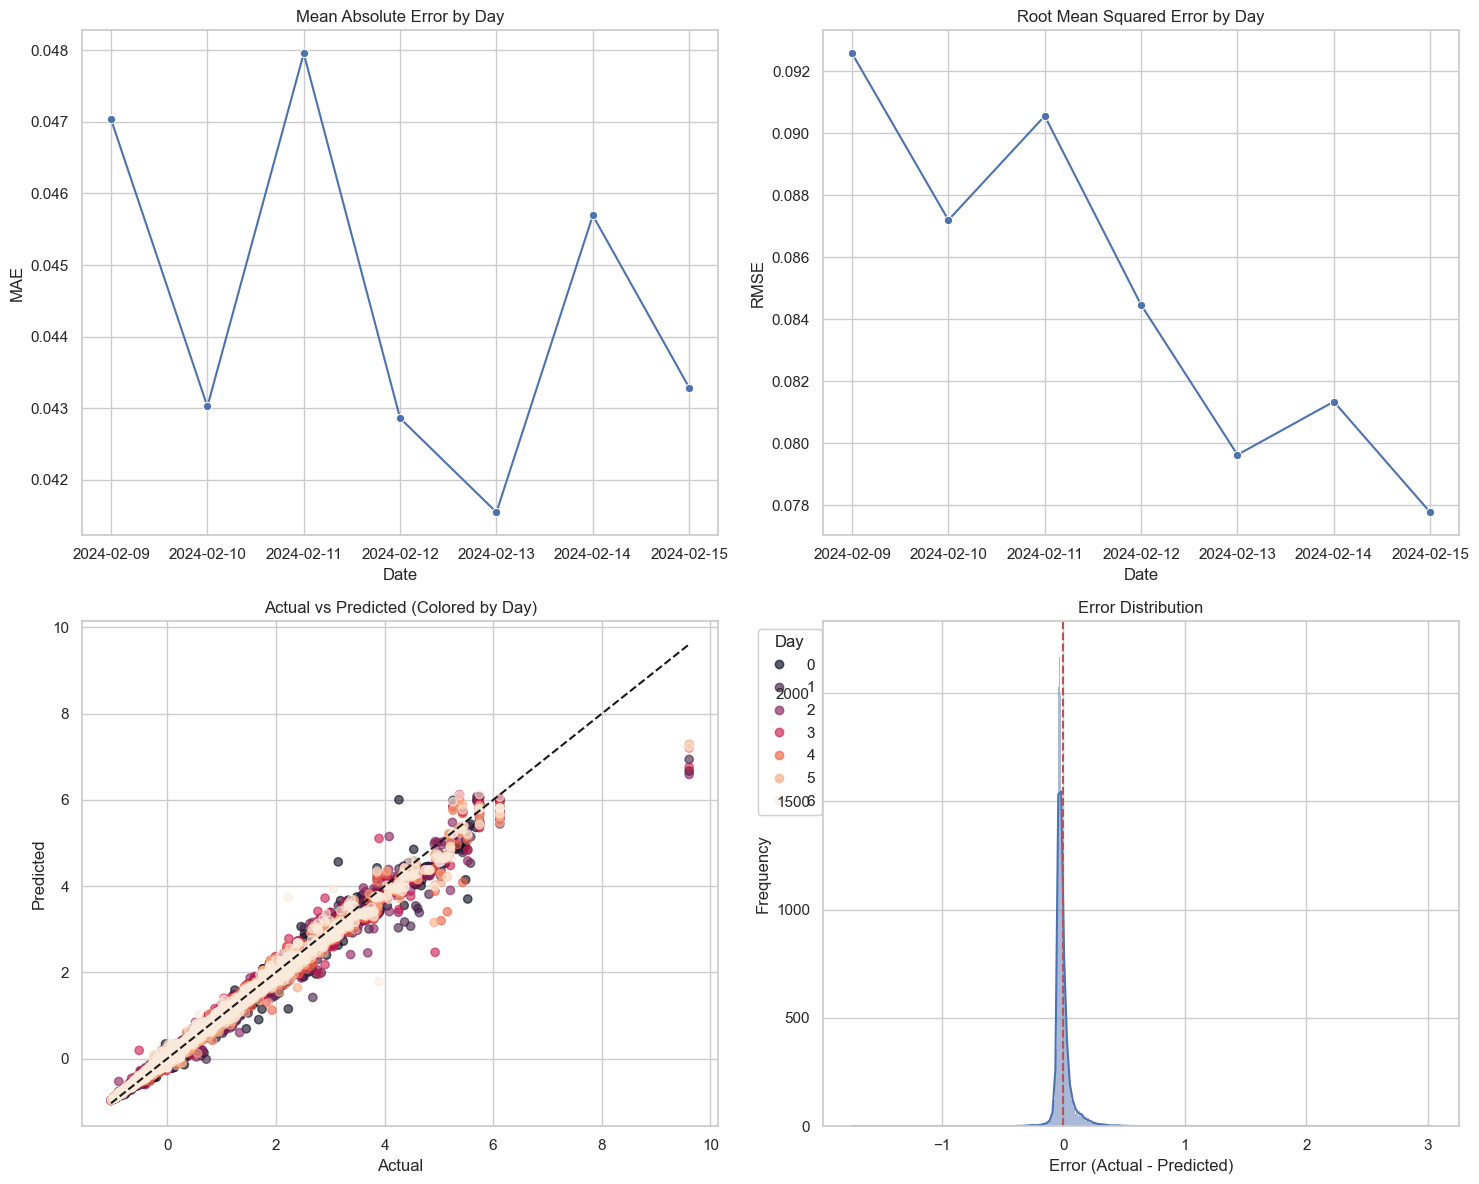

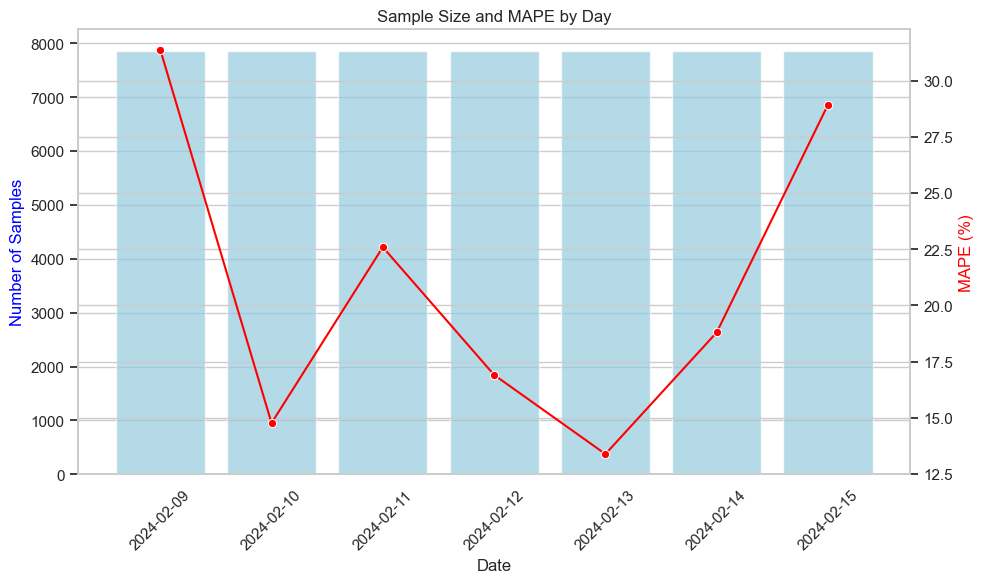

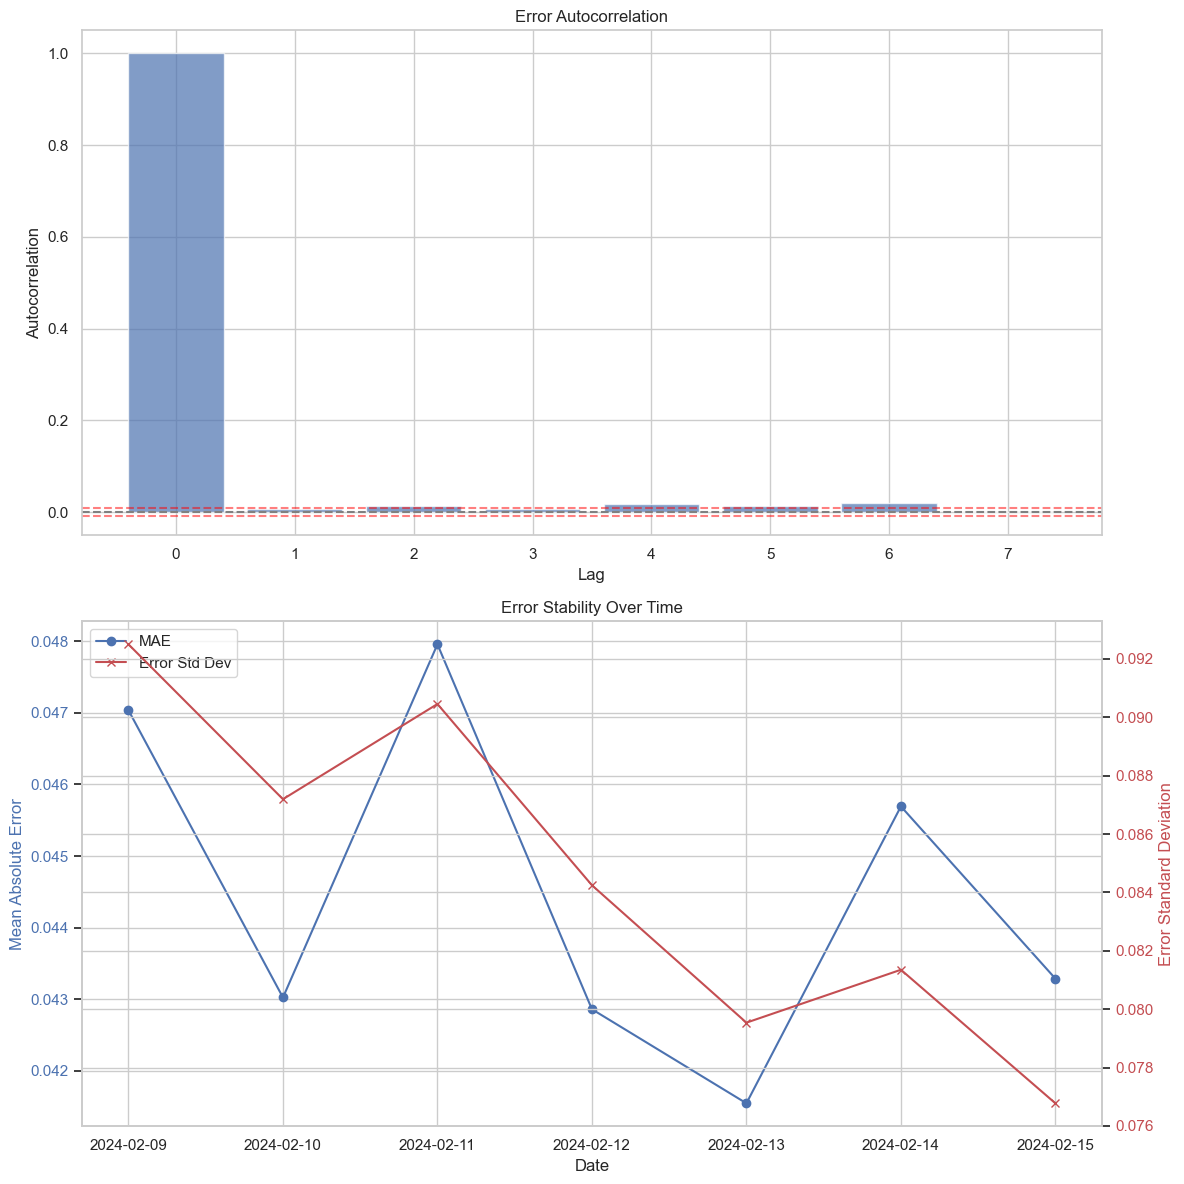

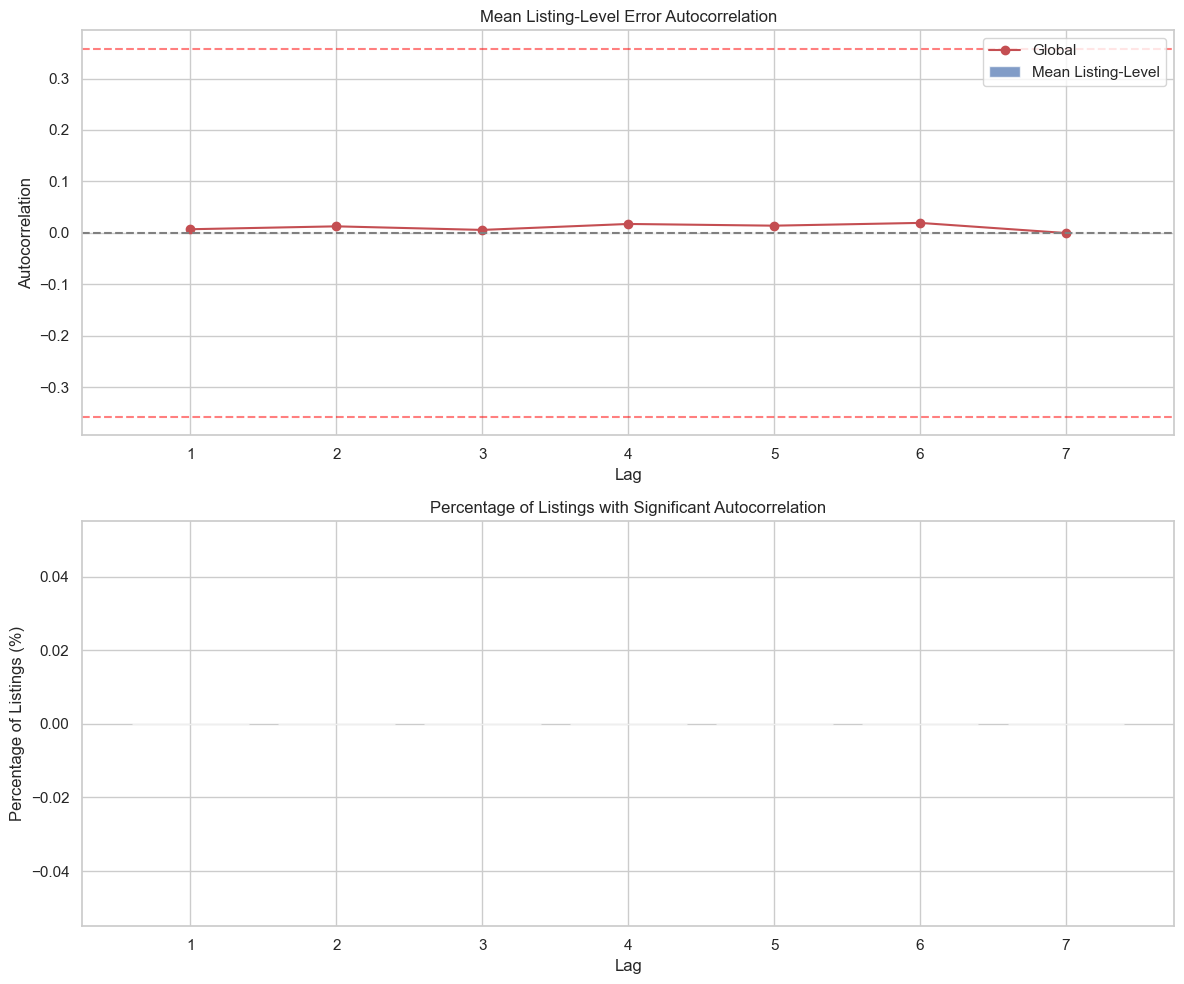

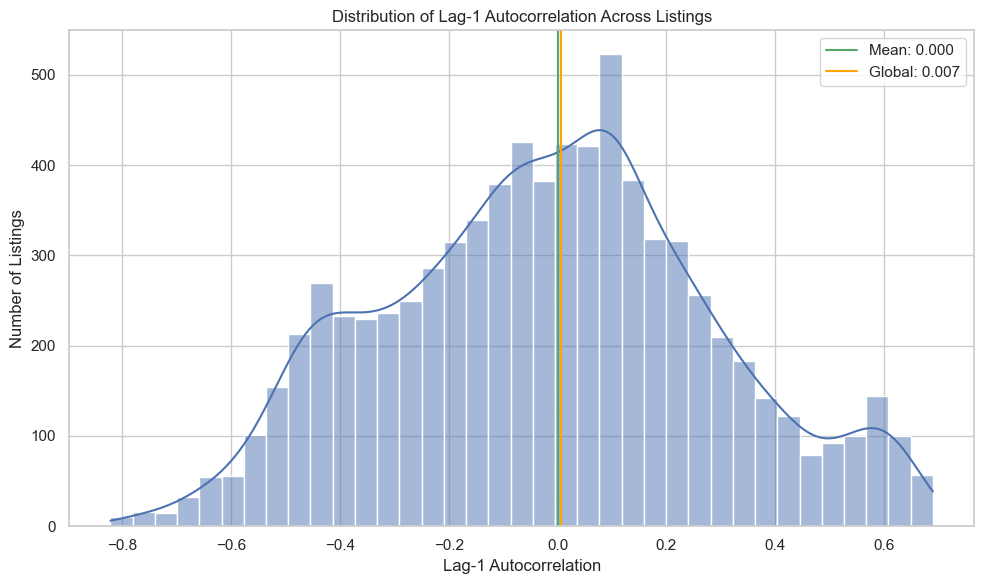

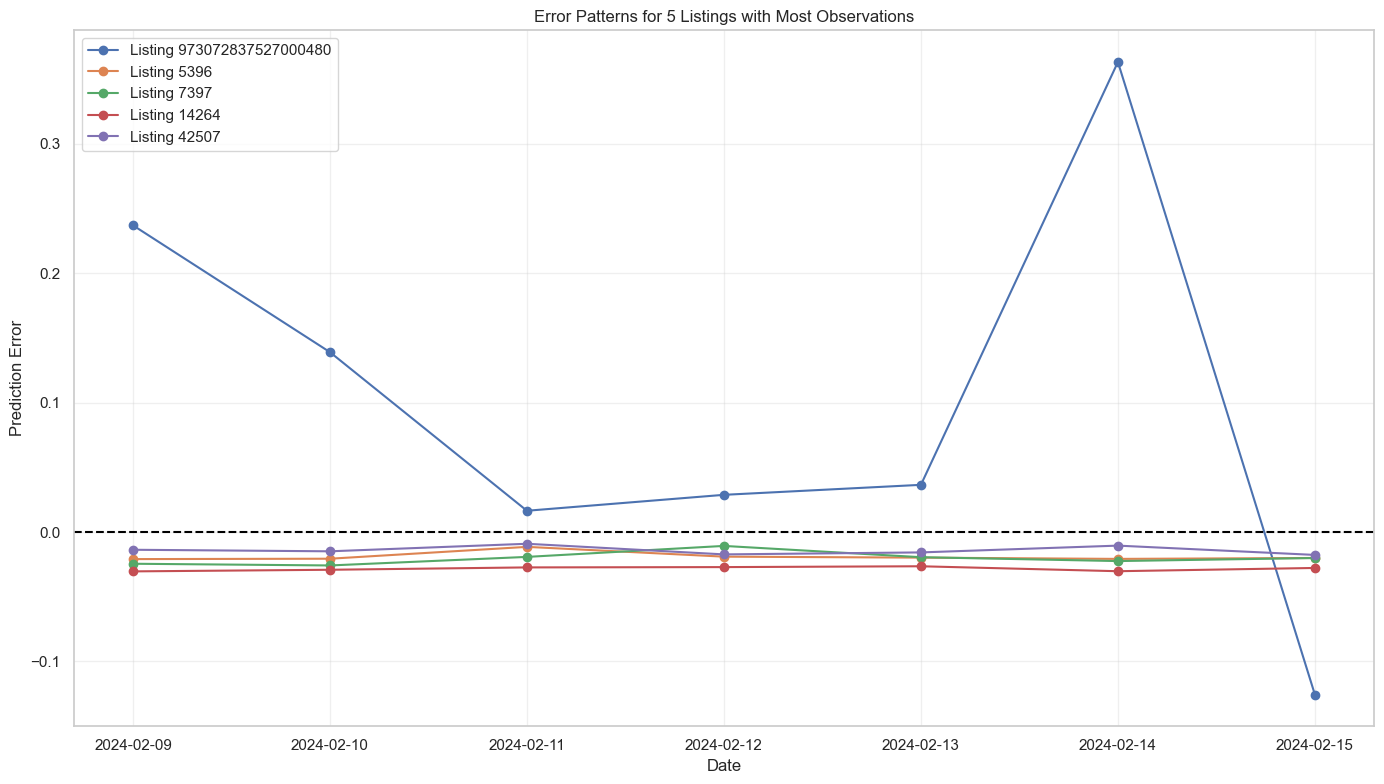


=== RUNNING MODEL WITHOUT 12 FEATURES ===
Processing dataset: train.csv
Features being dropped: ['rolling_mean_7d', 'rolling_max_7d', 'rolling_min_14d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_7d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d', 'price_lag_30d', 'price_lag_7d', 'price_lag_1d']
Loading data...
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_14d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_30d
Dropping column: rolling_max_30d
Dropping column: rolling_min_30d
Dropping column: price_lag_30d
Dropping column: price_lag_7d
Dropping column: price_lag_1d
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:48<04:51, 48.60s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 

DEBUG: all_results shape: (55048, 8)
DEBUG: columns available: ['date', 'listing_id', 'actual', 'predicted', 'abs_error', 'pct_error', 'error', 'date_str']
DEBUG: NaN in listing_id: 0
DEBUG: NaN in date: 0
DEBUG: NaN in error: 0
DEBUG: Number of unique listings: 7864
DEBUG: Listings with enough observations (>=3): 7864
DEBUG: Max observations per listing: 7
DEBUG: Min observations per listing: 7
DEBUG: Listing 5396, observations: 7
DEBUG: Dates: ['2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15']
DEBUG: Errors: [-0.3887862168471942, -0.33083844755177, -0.30335428530682423, -0.33211355435062745, -0.3527386799674163, -0.357517154536737, -0.3552803300540576]
DEBUG: Error calculating ACF for listing 5396: operands could not be broadcast together with shapes (7,) (6,) (7,) 
DEBUG: Listing 7397, observations: 7
DEBUG: Dates: ['2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15']
DEBUG: Errors: [-0.5796

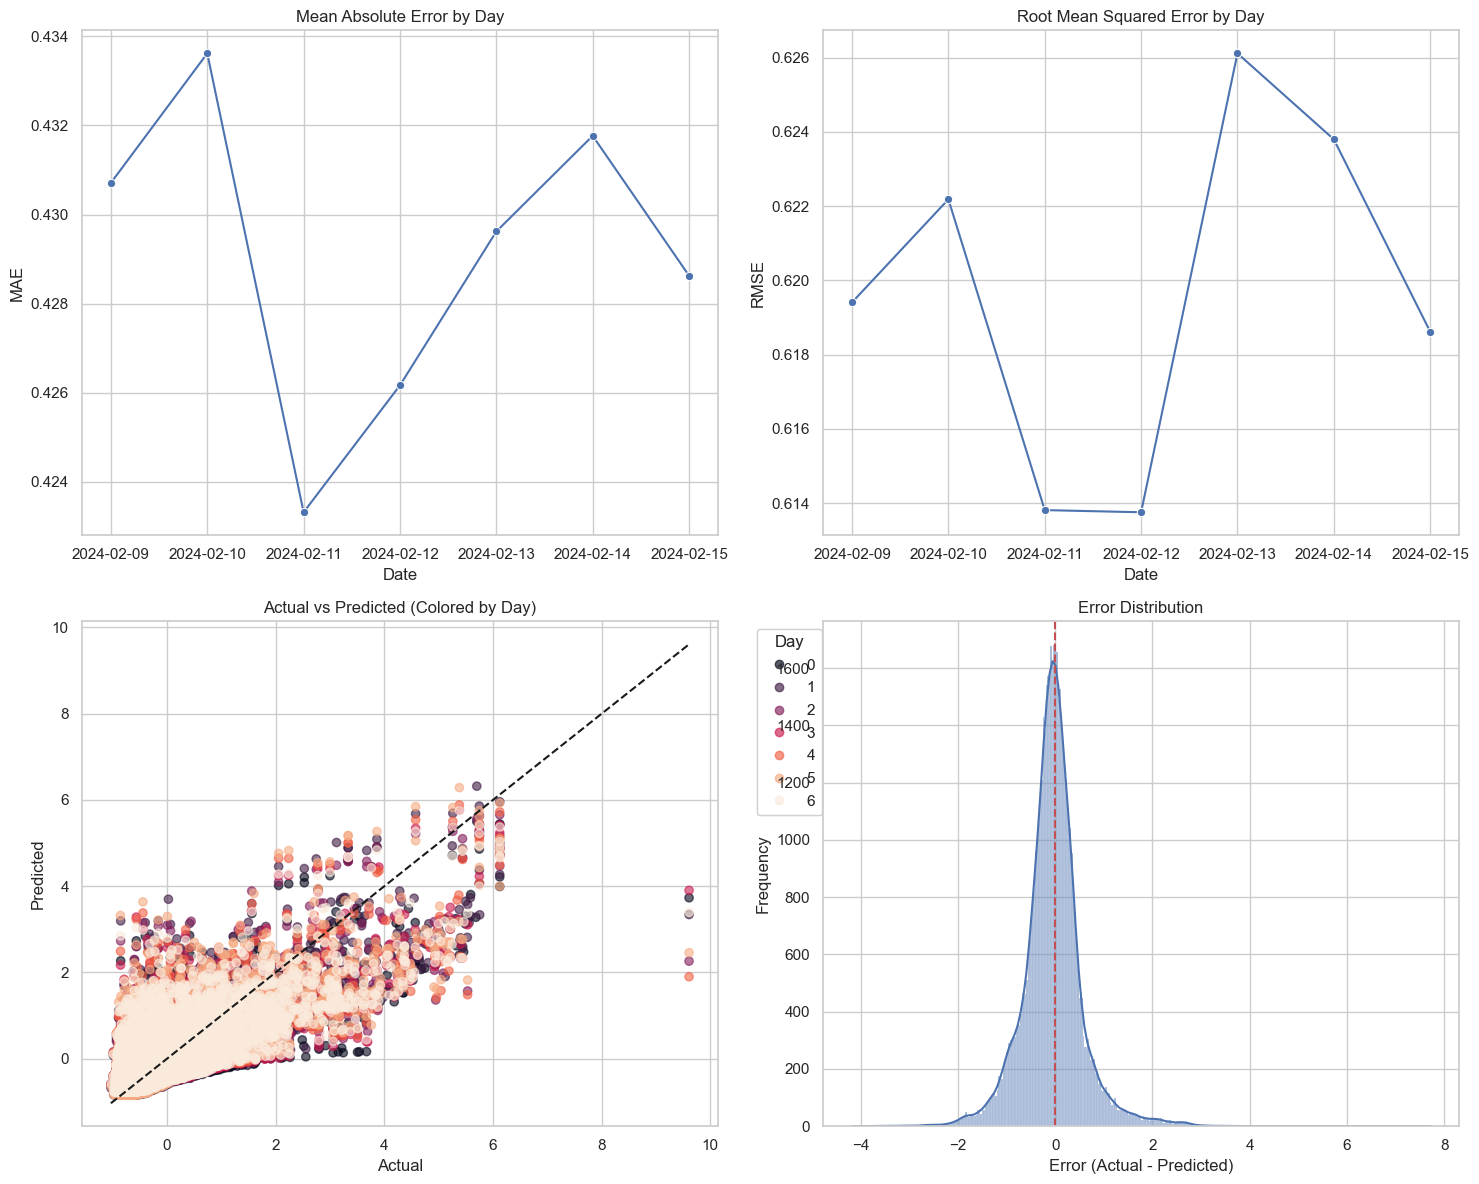

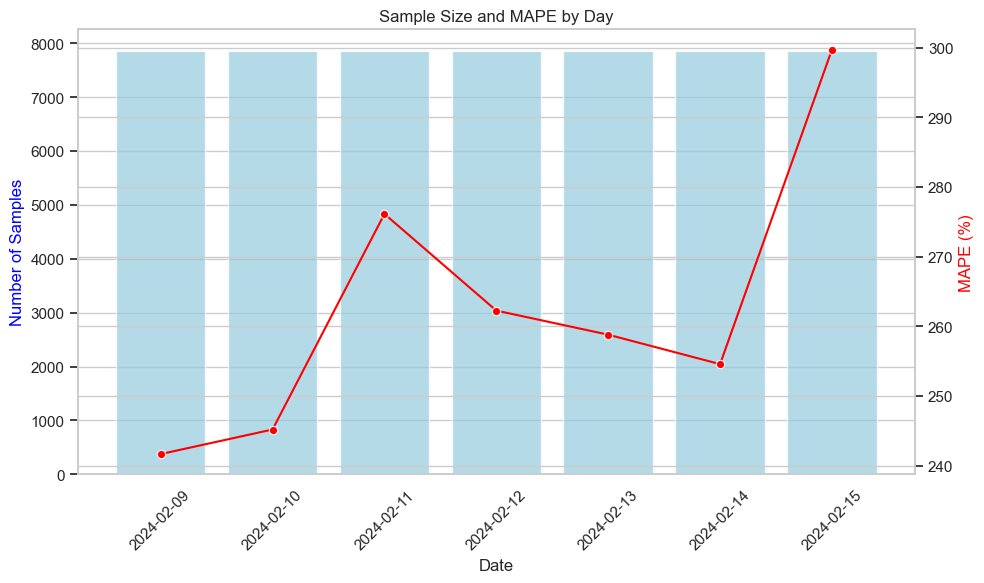

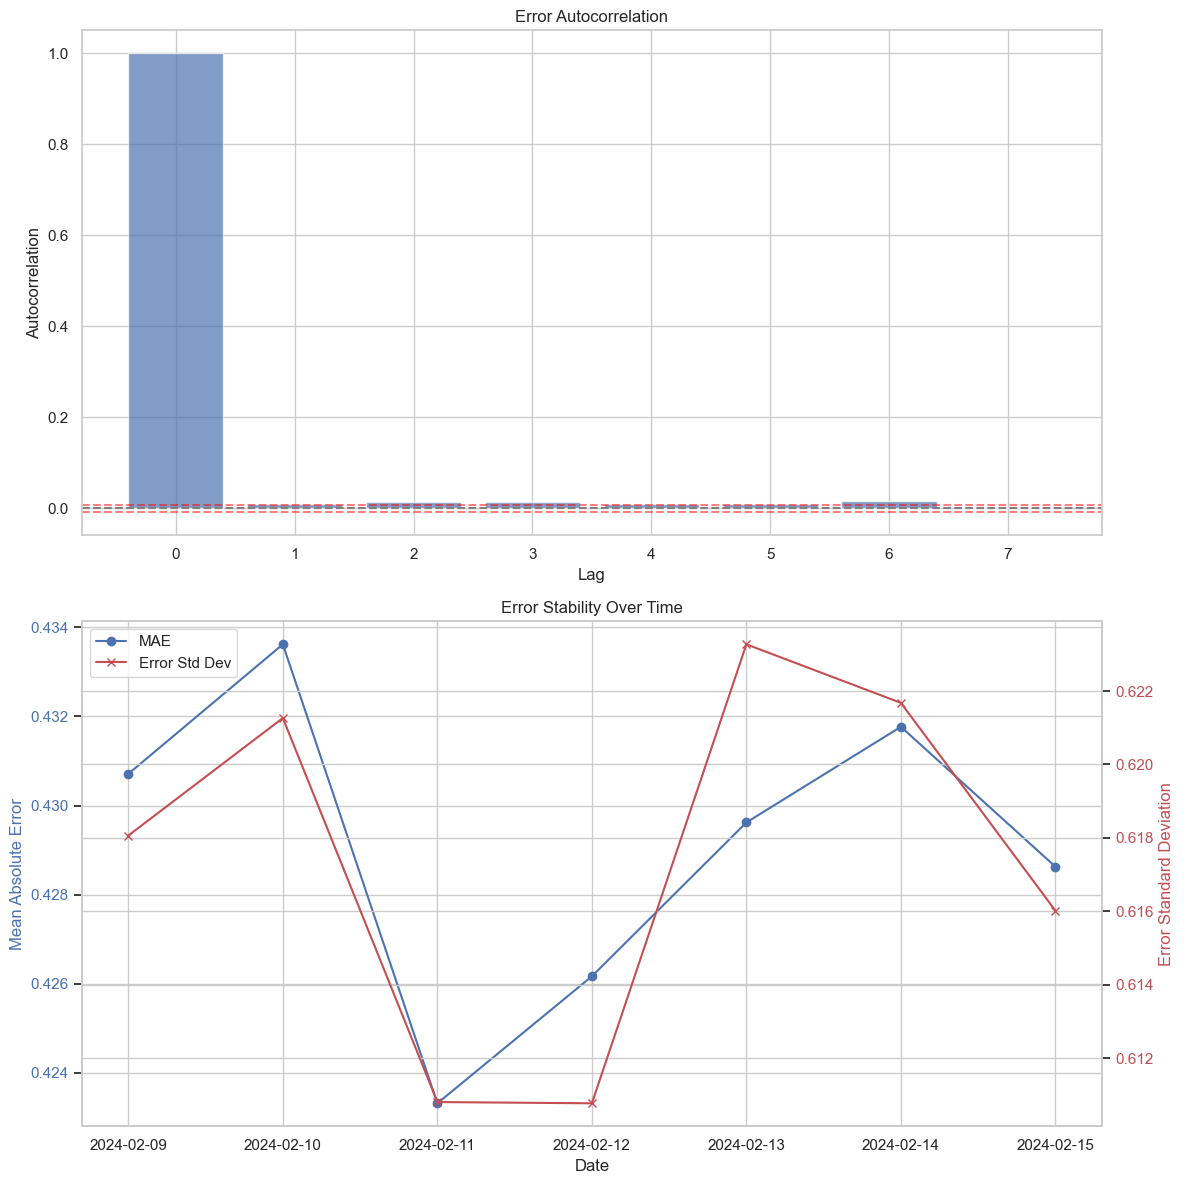

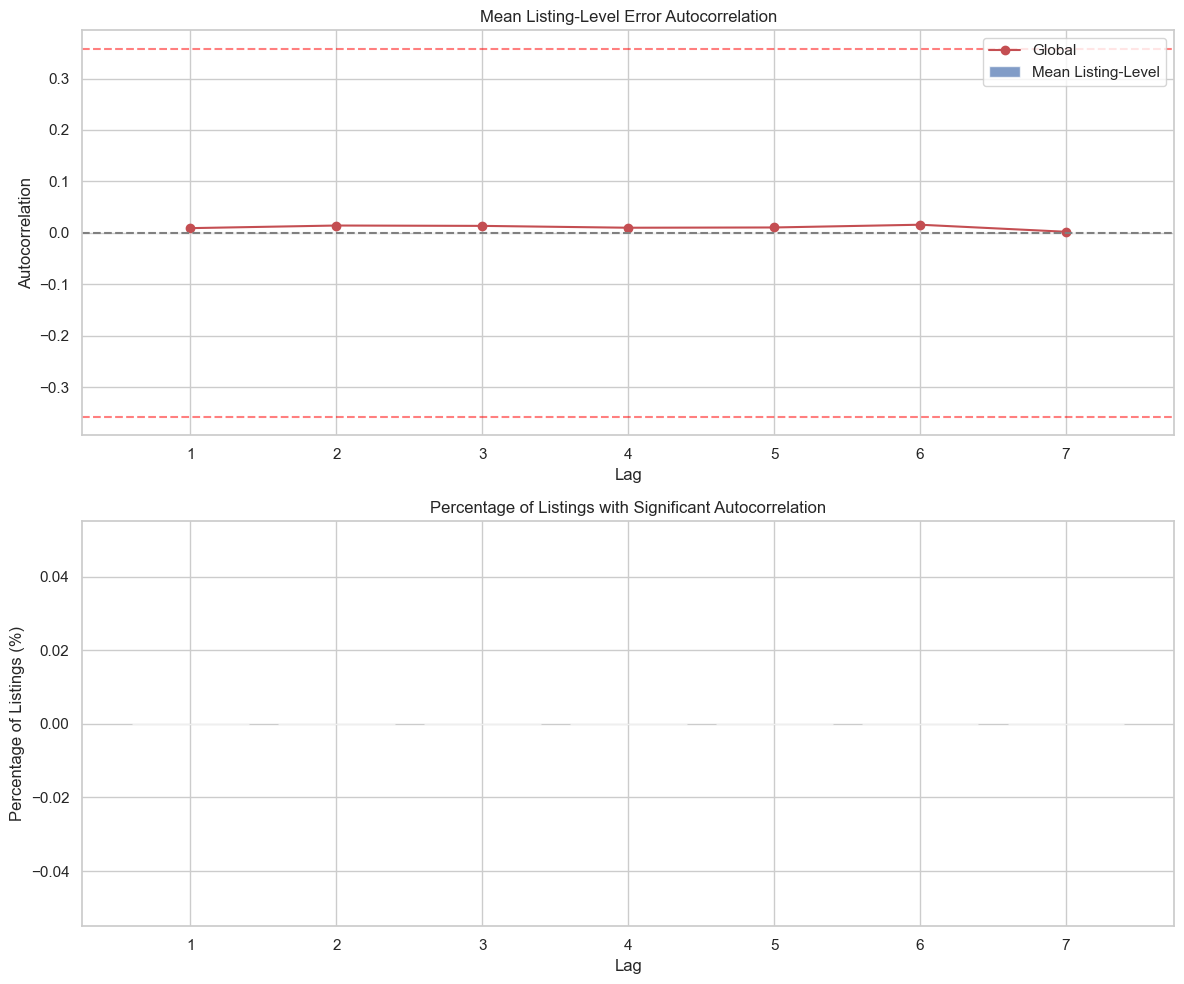

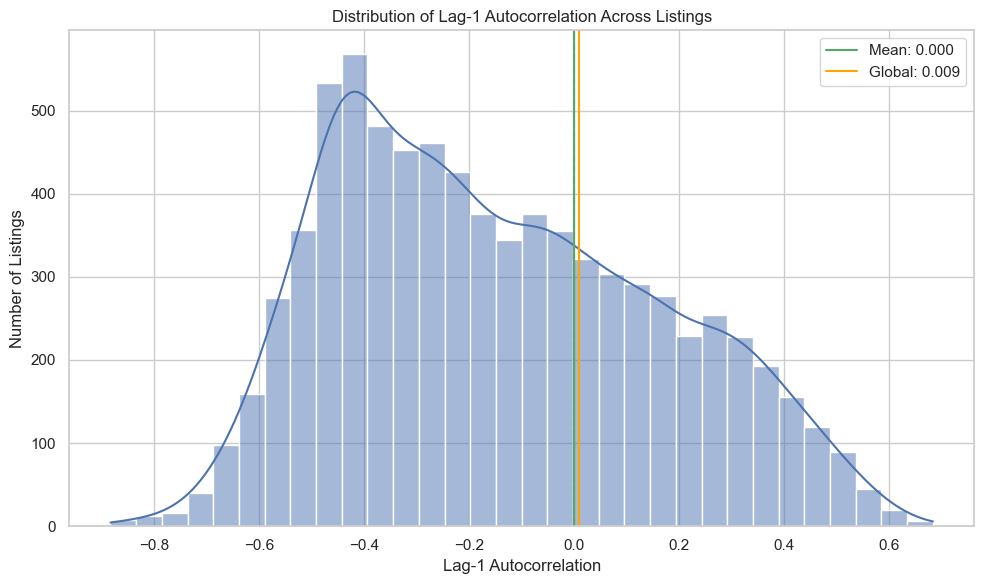

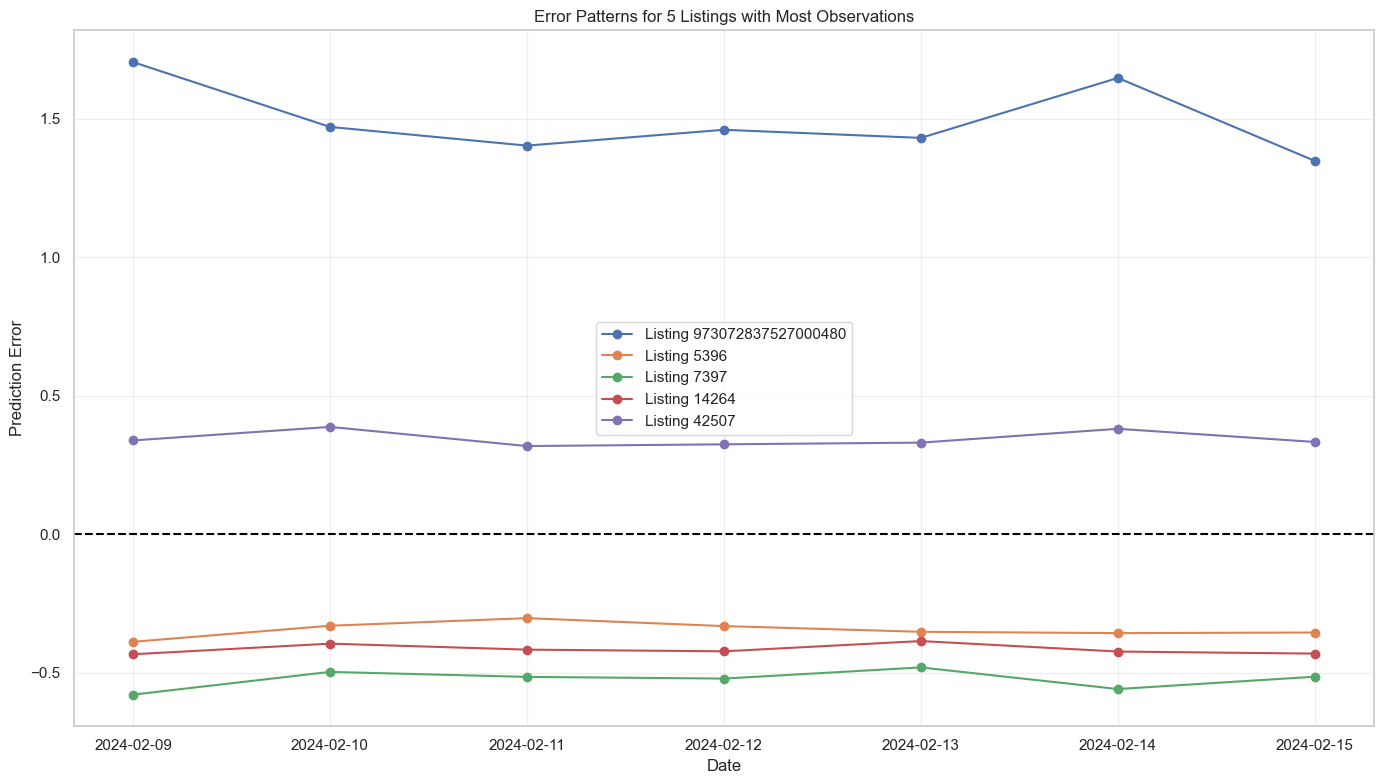


=== PERFORMANCE COMPARISON ===
Features dropped: rolling_mean_7d, rolling_max_7d, rolling_min_14d, rolling_mean_14d, rolling_max_14d, rolling_min_7d, rolling_mean_30d, rolling_max_30d, rolling_min_30d, price_lag_30d, price_lag_7d, price_lag_1d
Metric               Baseline        Ablation        Difference      % Change       
rmse                 0.084952        0.619686        0.534734        629.46         %
mae                  0.044486        0.429120        0.384633        864.61         %
r2                   0.991298        0.536962        0.454336        45.83          %
mape                 20.964135       262.602700      241.638565      1152.63        %
Stability Coef.      0.054157        0.008107        -0.046049       -85.03         %

Global Autocorrelation Comparison:
Lag        Baseline        Ablation        Difference     
-------------------------------------------------------
1          0.006989        0.009126        0.002137       
2          0.012621        0.0

In [9]:
# Example usage
if __name__ == "__main__":
    # # Simple example with defaults
    # results = run_ablation_experiment(
    #     subset_name="poorest_neighborhoods_subset", 
    #     test_period="test_feb"
    # )
    
    # Example of running multiple experiments in a loop
    subsets = ["top_price_changers_subset"]#, "top_expensive_listings_subset", "richest_neighborhoods_subset"]
    test_periods = ["test_feb"]
    
    all_results = {}
    for subset in subsets:
        all_results[subset] = {}
        for period in test_periods:
            print(f"\n\n========= TESTING {subset} - {period} =========")
            all_results[subset][period] = run_ablation_experiment(subset, period)


            